In [ ]:
!pip install liwc
!pip install transformers==4.24.0
!pip install datasets==2.7.1
!pip install evaluate==0.3.0

methods for CNN model:

1. features are vectors of the entire vocabulary with 1's representing existence of the word in the text
2. features are dictionary of feature counts within the vocabulary, bag of words
3. features are as defined in 1, but weights to the features are assigned using GloVe. GloVe is essentially a dictionary that maps a word to a vector of numbers that contains semantic information. A really cool example is when you subtract the vector of man from the vector of king, you get a similar vector to queen
4. features are defined through LIWC. LIWC takes each essay and converts it into a dictionary of either counts or percentages of words in the essay that adhere to 69 different linguistic and psychological categories. It is essentially a

In [ ]:
#imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns
import re
import urllib.request as req
import liwc
from collections import Counter
import scipy
from transformers import Trainer, TrainingArguments, AutoTokenizer
from keras.models import Model
from keras.layers import Concatenate, Dense, Input


In [ ]:
#import data essay_with_liwc
from google.colab import files
uploaded = files.upload()

Saving essay_with_LIWC.csv to essay_with_LIWC.csv


In [ ]:
#glove needs to be downloaded onto your google drive to access the file
from google.colab import drive
drive.mount('/content/drive')
embed_dict = {}
with open('/content/drive/MyDrive/glove.6B.100d.txt', 'r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    embed_dict[word]=vector



Mounted at /content/drive


In [ ]:
#label data
essay_data = uploaded["essay_with_LIWC.csv"]
df = pd.read_csv(io.BytesIO(essay_data), encoding='ISO-8859-1')
df.replace({'y': 1, 'n': 0}, inplace=True)
df.head()

,#AUTHID,TEXT,cEXT,cNEU,cAGR,cCON,cOPN,Segment,WC,Analytic,...,nonflu,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji
0,1997_504851.txt,"Well, right now I just woke up from a mid-day ...",0,1,1,0,1,1,661,12.91,...,0.00,0.00,15.58,4.99,5.14,0.61,0.00,3.93,0.91,0
1,1997_605191.txt,"Well, here we go with the stream of consciousn...",0,0,1,0,0,1,647,7.51,...,0.46,0.15,24.88,13.29,3.71,0.15,0.15,7.42,0.15,0
2,1997_687252.txt,An open keyboard and buttons to push. The thin...,0,1,0,1,1,1,752,29.48,...,0.00,0.00,11.30,8.38,0.27,0.13,0.00,1.73,0.80,0
3,1997_568848.txt,I can't believe it! It's really happening! M...,1,0,1,1,0,1,344,1.69,...,1.16,0.00,24.13,8.14,2.91,2.33,4.65,6.10,0.00,0
4,1997_688160.txt,"Well, here I go with the good old stream of co...",1,0,1,0,1,1,909,18.95,...,0.11,0.11,23.43,6.05,9.02,0.33,0.55,5.61,1.87,0


In [ ]:
#evaluate model
def evaluate(model, X_test, y_test):
  loss, accuracy = model.evaluate(X_test, y_test)
  print(f'Test Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

  predictions = model.predict(X_test)
  binary_predictions = (predictions >= 0.5).astype(int)

  personality_traits = ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']
  accuracy_dict = {}
  precision_dict = {}
  recall_dict = {}
  f1_dict = {}
  conf_matrix_dict = {}

  for i, trait in enumerate(personality_traits):
      y_test_trait = y_test[:, i]
      binary_predictions_trait = binary_predictions[:, i]
      accuracy_dict[trait] = accuracy_score(y_test_trait, binary_predictions_trait)
      precision_dict[trait] = precision_score(y_test_trait, binary_predictions_trait)
      recall_dict[trait] = recall_score(y_test_trait, binary_predictions_trait)
      f1_dict[trait] = f1_score(y_test_trait, binary_predictions_trait)
      conf_matrix_dict[trait] = confusion_matrix(y_test_trait, binary_predictions_trait)

  for trait in personality_traits:
      print(f'Personality Trait: {trait}')
      print(f'Accuracy: {accuracy_dict[trait]:.4f}')
      print(f'Precision: {precision_dict[trait]:.4f}')
      print(f'Recall: {recall_dict[trait]:.4f}')
      print(f'F1 Score: {f1_dict[trait]:.4f}')
      print('Confusion Matrix:')
      print(conf_matrix_dict[trait])
      print('\n')

In [ ]:
#features are bag of words
vectorizer = CountVectorizer(min_df=0)
X_bow = vectorizer.fit_transform(df["TEXT"]).toarray()
y_bow = df[['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']].values
y_bow = y_bow.astype('float32')
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, y_bow, test_size = .2, random_state = 42)
vocab_size = len(vectorizer.vocabulary_)

model_bow = Sequential()
model_bow.add(layers.Embedding(input_dim=vocab_size + 1, output_dim=100, input_length=X_bow.shape[1], trainable=False))
model_bow.add(layers.Conv1D(128, 5, activation='relu'))
model_bow.add(layers.GlobalMaxPooling1D())
model_bow.add(layers.Dense(64, activation='relu'))
model_bow.add(layers.Dense(5, activation='sigmoid'))

model_bow.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


#train model
model_bow.fit(X_train_bow, y_train_bow, epochs=5, batch_size=32, validation_split=0.2)



In [ ]:
evaluate(model_bow, X_test_bow, y_test_bow)

In [ ]:
#fine tune glove model
epochs_values = [5, 10, 15, 20, 25]
random_state_values = [42, 123, 456, 789, 1000]
results = {}

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['TEXT'])
sequences = tokenizer.texts_to_sequences(df['TEXT'])

word_index = tokenizer.word_index
max_sequence_length = max(len(seq) for seq in sequences)

X_glove = pad_sequences(sequences, maxlen=max_sequence_length)
y_glove = df[['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']].values
y_glove = y_glove.astype('float32')


embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embed_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


for epochs in epochs_values:
  for random_state in random_state_values:
    X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(X_glove, y_glove, test_size=0.2, random_state=random_state)

    model_glove = Sequential()
    model_glove.add(layers.Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
    model_glove.add(layers.Conv1D(128, 5, activation='relu'))
    model_glove.add(layers.GlobalMaxPooling1D())
    model_glove.add(layers.Dense(64, activation='relu'))
    model_glove.add(layers.Dense(5, activation='sigmoid'))

    model_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model_glove.fit(X_train_glove, y_train_glove, epochs=epochs, batch_size=32, validation_split=0.2)
    evaluation = model_glove.evaluate(X_test_glove, y_test_glove, verbose=0)
    results[(epochs, random_state)] = {
        'loss': evaluation[0],
        'accuracy': evaluation[1]
    }

for params, metrics in results.items():
    print(f"Epochs: {params[0]}, Random State: {params[1]} - Loss: {metrics['loss']}, Accuracy: {metrics['accuracy']}")


'''
Epochs: 5, Random State: 42 - Loss: 0.6966913938522339, Accuracy: 0.16194331645965576
Epochs: 5, Random State: 123 - Loss: 0.6925433278083801, Accuracy: 0.04858299717307091
Epochs: 5, Random State: 456 - Loss: 0.6940311789512634, Accuracy: 0.12753036618232727
Epochs: 5, Random State: 789 - Loss: 0.6911214590072632, Accuracy: 0.11133603006601334
Epochs: 5, Random State: 1000 - Loss: 0.6890402436256409, Accuracy: 0.1558704525232315
Epochs: 10, Random State: 42 - Loss: 0.7822646498680115, Accuracy: 0.24089068174362183
Epochs: 10, Random State: 123 - Loss: 0.7400863766670227, Accuracy: 0.22874493896961212
Epochs: 10, Random State: 456 - Loss: 0.7491190433502197, Accuracy: 0.11133603006601334
Epochs: 10, Random State: 789 - Loss: 0.72941654920578, Accuracy: 0.16396760940551758
Epochs: 10, Random State: 1000 - Loss: 0.7950494885444641, Accuracy: 0.19838055968284607
Epochs: 15, Random State: 42 - Loss: 0.8516961932182312, Accuracy: 0.21862348914146423
Epochs: 15, Random State: 123 - Loss: 0.8174274563789368, Accuracy: 0.2510121464729309
Epochs: 15, Random State: 456 - Loss: 0.8425046801567078, Accuracy: 0.24089068174362183
Epochs: 15, Random State: 789 - Loss: 0.8217289447784424, Accuracy: 0.20647773146629333
Epochs: 15, Random State: 1000 - Loss: 0.8271195888519287, Accuracy: 0.2246963530778885
Epochs: 20, Random State: 42 - Loss: 1.0607869625091553, Accuracy: 0.20445343852043152
Epochs: 20, Random State: 123 - Loss: 0.9981368184089661, Accuracy: 0.1680161952972412
Epochs: 20, Random State: 456 - Loss: 0.9991801977157593, Accuracy: 0.2489878535270691
Epochs: 20, Random State: 789 - Loss: 0.9833925366401672, Accuracy: 0.30161944031715393
Epochs: 20, Random State: 1000 - Loss: 0.9616855978965759, Accuracy: 0.19230769574642181
Epochs: 25, Random State: 42 - Loss: 1.129407286643982, Accuracy: 0.19635628163814545
Epochs: 25, Random State: 123 - Loss: 1.0139274597167969, Accuracy: 0.23481781780719757
Epochs: 25, Random State: 456 - Loss: 1.0787428617477417, Accuracy: 0.2145749032497406
Epochs: 25, Random State: 789 - Loss: 1.0635532140731812, Accuracy: 0.2489878535270691
Epochs: 25, Random State: 1000 - Loss: 1.1222151517868042, Accuracy: 0.2145749032497406
'''

In [ ]:
#train best glove model
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['TEXT'])
sequences = tokenizer.texts_to_sequences(df['TEXT'])

word_index = tokenizer.word_index
max_sequence_length = max(len(seq) for seq in sequences)

X_glove = pad_sequences(sequences, maxlen=max_sequence_length)
y_glove = df[['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']].values
y_glove = y_glove.astype('float32')


embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embed_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(X_glove, y_glove, test_size=0.2, random_state=789)

model_glove = Sequential()
model_glove.add(layers.Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model_glove.add(layers.Conv1D(128, 5, activation='relu'))
model_glove.add(layers.GlobalMaxPooling1D())
model_glove.add(layers.Dense(64, activation='relu'))
model_glove.add(layers.Dense(5, activation='sigmoid'))

model_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_glove.fit(X_train_glove, y_train_glove, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
50/50 [==============================] - 3s 31ms/step - loss: 0.7258 - accuracy: 0.2161 - val_loss: 0.7059 - val_accuracy: 0.1013
Epoch 2/20
50/50 [==============================] - 1s 17ms/step - loss: 0.6699 - accuracy: 0.2332 - val_loss: 0.6887 - val_accuracy: 0.1392
Epoch 3/20
50/50 [==============================] - 1s 14ms/step - loss: 0.6353 - accuracy: 0.2161 - val_loss: 0.6957 - val_accuracy: 0.0810
Epoch 4/20
50/50 [==============================] - 1s 16ms/step - loss: 0.6046 - accuracy: 0.2649 - val_loss: 0.7022 - val_accuracy: 0.3291
Epoch 5/20
50/50 [==============================] - 1s 18ms/step - loss: 0.5633 - accuracy: 0.2883 - val_loss: 0.6925 - val_accuracy: 0.2658
Epoch 6/20
50/50 [==============================] - 1s 26ms/step - loss: 0.5172 - accuracy: 0.3384 - val_loss: 0.7058 - val_accuracy: 0.2506
Epoch 7/20
50/50 [==============================] - 1s 28ms/step - loss: 0.4611 - accuracy: 0.3549 - val_loss: 0.7101 - val_accuracy: 0.2759
Epoch 8/20
50

In [ ]:
evaluate(model_glove, X_test_glove, y_test_glove)

16/16 [==============================] - 0s 15ms/step - loss: 1.0423 - accuracy: 0.2166
Test Loss: 1.0423, Accuracy: 0.2166
16/16 [==============================] - 0s 7ms/step
Personality Trait: cEXT
Accuracy: 0.5081
Precision: 0.5274
Recall: 0.4883
F1 Score: 0.5071
Confusion Matrix:
[[126 112]
 [131 125]]


Personality Trait: cNEU
Accuracy: 0.5081
Precision: 0.5050
Recall: 0.6179
F1 Score: 0.5558
Confusion Matrix:
[[ 99 149]
 [ 94 152]]


Personality Trait: cAGR
Accuracy: 0.5709
Precision: 0.5926
Recall: 0.6592
F1 Score: 0.6241
Confusion Matrix:
[[106 121]
 [ 91 176]]


Personality Trait: cCON
Accuracy: 0.5385
Precision: 0.5374
Recall: 0.6064
F1 Score: 0.5698
Confusion Matrix:
[[115 130]
 [ 98 151]]


Personality Trait: cOPN
Accuracy: 0.6235
Precision: 0.6524
Recall: 0.5480
F1 Score: 0.5957
Confusion Matrix:
[[171  73]
 [113 137]]




In [ ]:
#fine tune hyperparameters LIWC
epochs_values = [5, 10, 15, 20, 25]
random_state_values = [42, 123, 456, 789, 1000]

results = {}


X_liwc = df.iloc[:, 7:]
y_liwc = df[['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']].values
y_liwc = y_liwc.astype('float32')

for epochs in epochs_values:
    for random_state in random_state_values:
        X_liwc_train, X_liwc_test, y_liwc_train, y_liwc_test = train_test_split(X_liwc, y_liwc, test_size=0.2, random_state=random_state)
        size = int(X_liwc_train.max().max() + 1)

        model_liwc = Sequential()
        model_liwc.add(layers.Embedding(input_dim=size, output_dim=100, input_length=X_liwc_train.shape[1], trainable=False))
        model_liwc.add(layers.Conv1D(128, 5, activation='relu'))
        model_liwc.add(layers.GlobalMaxPooling1D())
        model_liwc.add(layers.Dense(64, activation='relu'))
        model_liwc.add(layers.Dense(5, activation='sigmoid'))

        model_liwc.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model_liwc.fit(X_liwc_train, y_liwc_train, epochs=epochs, batch_size=32, validation_split=0.2, verbose=0)

        evaluation = model_liwc.evaluate(X_liwc_test, y_liwc_test, verbose=0)

        results[(epochs, random_state)] = {
            'loss': evaluation[0],
            'accuracy': evaluation[1]
        }

# Print the results
for params, metrics in results.items():
    print(f"Epochs: {params[0]}, Random State: {params[1]} - Loss: {metrics['loss']}, Accuracy: {metrics['accuracy']}")


'''
Epochs: 5, Random State: 42 - Loss: 0.6927007436752319, Accuracy: 0.24696356058120728
Epochs: 5, Random State: 123 - Loss: 0.6927765607833862, Accuracy: 0.10323886573314667
Epochs: 5, Random State: 456 - Loss: 0.6935886740684509, Accuracy: 0.10931174457073212
Epochs: 5, Random State: 789 - Loss: 0.6926708221435547, Accuracy: 0.1781376451253891
Epochs: 5, Random State: 1000 - Loss: 0.6939026117324829, Accuracy: 0.17004048824310303
Epochs: 10, Random State: 42 - Loss: 0.7166160345077515, Accuracy: 0.21862348914146423
Epochs: 10, Random State: 123 - Loss: 0.7013407349586487, Accuracy: 0.23481781780719757
Epochs: 10, Random State: 456 - Loss: 0.7001879811286926, Accuracy: 0.1315789520740509
Epochs: 10, Random State: 789 - Loss: 0.7046115398406982, Accuracy: 0.22874493896961212
Epochs: 10, Random State: 1000 - Loss: 0.7013539671897888, Accuracy: 0.20040485262870789
Epochs: 15, Random State: 42 - Loss: 0.7767276167869568, Accuracy: 0.23076923191547394
Epochs: 15, Random State: 123 - Loss: 0.7446218729019165, Accuracy: 0.15991902351379395
Epochs: 15, Random State: 456 - Loss: 0.7556310892105103, Accuracy: 0.20040485262870789
Epochs: 15, Random State: 789 - Loss: 0.7698819041252136, Accuracy: 0.18421052396297455
Epochs: 15, Random State: 1000 - Loss: 0.7420262694358826, Accuracy: 0.28947368264198303
Epochs: 20, Random State: 42 - Loss: 0.8427063822746277, Accuracy: 0.15789473056793213
Epochs: 20, Random State: 123 - Loss: 0.8466253280639648, Accuracy: 0.24291497468948364
Epochs: 20, Random State: 456 - Loss: 0.8448910117149353, Accuracy: 0.21255061030387878
Epochs: 20, Random State: 789 - Loss: 0.8658473491668701, Accuracy: 0.2024291455745697
Epochs: 20, Random State: 1000 - Loss: 0.8501887917518616, Accuracy: 0.23481781780719757
Epochs: 25, Random State: 42 - Loss: 0.9710164666175842, Accuracy: 0.21255061030387878
Epochs: 25, Random State: 123 - Loss: 0.9141055345535278, Accuracy: 0.1659919023513794
Epochs: 25, Random State: 456 - Loss: 0.9133543968200684, Accuracy: 0.17408907413482666
Epochs: 25, Random State: 789 - Loss: 0.8709120750427246, Accuracy: 0.20850202441215515
Epochs: 25, Random State: 1000 - Loss: 0.9369744062423706, Accuracy: 0.18016193807125092
'''

In [ ]:
#train best LIWC model

X_liwc = df.iloc[:, 7:]
y_liwc = df[['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']].values
y_liwc = y_liwc.astype('float32')
X_liwc_train, X_liwc_test, y_liwc_train, y_liwc_test = train_test_split(X_liwc, y_liwc, test_size = .2, random_state = 1000)
size = int(X_liwc_train.max().max() + 1)


model_liwc = Sequential()
model_liwc.add(layers.Embedding(input_dim=size, output_dim=100, input_length=X_liwc_train.shape[1], trainable=False))
model_liwc.add(layers.Conv1D(128, 5, activation='relu'))
model_liwc.add(layers.GlobalMaxPooling1D())
model_liwc.add(layers.Dense(64, activation='relu'))
model_liwc.add(layers.Dense(5, activation='sigmoid'))  # Assuming 5 personality traits

model_liwc.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_liwc.fit(X_liwc_train, y_liwc_train, epochs=15, batch_size=32, validation_split=0.2)


Epoch 1/15
50/50 [==============================] - 4s 11ms/step - loss: 0.6934 - accuracy: 0.3308 - val_loss: 0.6946 - val_accuracy: 0.0127
Epoch 2/15
50/50 [==============================] - 0s 7ms/step - loss: 0.6905 - accuracy: 0.0621 - val_loss: 0.6953 - val_accuracy: 0.0127
Epoch 3/15
50/50 [==============================] - 0s 7ms/step - loss: 0.6878 - accuracy: 0.1850 - val_loss: 0.6943 - val_accuracy: 0.3089
Epoch 4/15
50/50 [==============================] - 0s 7ms/step - loss: 0.6835 - accuracy: 0.2624 - val_loss: 0.6972 - val_accuracy: 0.2025
Epoch 5/15
50/50 [==============================] - 0s 7ms/step - loss: 0.6777 - accuracy: 0.2427 - val_loss: 0.6932 - val_accuracy: 0.0987
Epoch 6/15
50/50 [==============================] - 0s 6ms/step - loss: 0.6682 - accuracy: 0.3029 - val_loss: 0.6946 - val_accuracy: 0.0354
Epoch 7/15
50/50 [==============================] - 0s 8ms/step - loss: 0.6513 - accuracy: 0.2921 - val_loss: 0.6922 - val_accuracy: 0.1013
Epoch 8/15
50/50 [=

In [ ]:
evaluate(model_liwc, X_liwc_test, y_liwc_test)

16/16 [==============================] - 0s 7ms/step - loss: 0.7644 - accuracy: 0.2874
Test Loss: 0.7644, Accuracy: 0.2874
16/16 [==============================] - 0s 3ms/step
Personality Trait: cEXT
Accuracy: 0.5324
Precision: 0.5300
Recall: 0.6048
F1 Score: 0.5650
Confusion Matrix:
[[113 133]
 [ 98 150]]


Personality Trait: cNEU
Accuracy: 0.5445
Precision: 0.5294
Recall: 0.5975
F1 Score: 0.5614
Confusion Matrix:
[[125 128]
 [ 97 144]]


Personality Trait: cAGR
Accuracy: 0.4676
Precision: 0.5349
Recall: 0.3345
F1 Score: 0.4116
Confusion Matrix:
[[139  80]
 [183  92]]


Personality Trait: cCON
Accuracy: 0.5000
Precision: 0.4980
Recall: 0.5122
F1 Score: 0.5050
Confusion Matrix:
[[121 127]
 [120 126]]


Personality Trait: cOPN
Accuracy: 0.5486
Precision: 0.5159
Recall: 0.5628
F1 Score: 0.5383
Confusion Matrix:
[[141 122]
 [101 130]]




In [ ]:
#merge LIWC and GloVe models
epochs_values = [5, 10, 15, 20, 25]
batch_size_values = [15, 32, 50, 75, 100]

results = {}
input_liwc = Input(shape=(X_liwc_train.shape[1],))
input_glove = Input(shape=(max_sequence_length,))

output_liwc = model_liwc(input_liwc)
output_glove = model_glove(input_glove)

combined = Concatenate()([output_liwc, output_glove])
combined = Dense(128, activation='relu')(combined)
combined = Dense(64, activation='relu')(combined)

output = Dense(5, activation='sigmoid')(combined)  # Assuming 5 personality traits

combined_model = Model(inputs=[input_liwc, input_glove], outputs=output)

combined_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

for epochs in epochs_values:
  for batchSize in batch_size_values:
    combined_model.fit([X_liwc_train, X_train_glove], y_train_glove, epochs=epochs, batch_size=batchSize, validation_split=0.2)
    evaluation = combined_model.evaluate( [X_liwc_test, X_test_glove], y_test_glove, verbose=0)
    results[(epochs, batchSize)] = {
        'loss': evaluation[0],
        'accuracy': evaluation[1]
    }

for params, metrics in results.items():
    print(f"Epochs: {params[0]}, Random State: {params[1]} - Loss: {metrics['loss']}, Accuracy: {metrics['accuracy']}")


'''
Epochs: 5, Batch Size: 15 - Loss: 1.9200948476791382, Accuracy: 0.19230769574642181
Epochs: 5, Batch Size: 32 - Loss: 2.133047342300415, Accuracy: 0.19230769574642181
Epochs: 5, Batch Size: 50 - Loss: 2.25809907913208, Accuracy: 0.19433198869228363
Epochs: 5, Batch Size: 75 - Loss: 2.4319441318511963, Accuracy: 0.21862348914146423
Epochs: 5, Batch Size: 100 - Loss: 2.5623176097869873, Accuracy: 0.23076923191547394
Epochs: 10, Batch Size: 15 - Loss: 3.7293717861175537, Accuracy: 0.18623481690883636
Epochs: 10, Batch Size: 32 - Loss: 4.108558654785156, Accuracy: 0.18016193807125092
Epochs: 10, Batch Size: 50 - Loss: 4.2785749435424805, Accuracy: 0.19028340280056
Epochs: 10, Batch Size: 75 - Loss: 4.378066539764404, Accuracy: 0.19433198869228363
Epochs: 10, Batch Size: 100 - Loss: 4.4446868896484375, Accuracy: 0.19433198869228363
Epochs: 15, Batch Size: 15 - Loss: 4.9742817878723145, Accuracy: 0.21862348914146423
Epochs: 15, Batch Size: 32 - Loss: 5.163370609283447, Accuracy: 0.2246963530778885
Epochs: 15, Batch Size: 50 - Loss: 5.273519039154053, Accuracy: 0.23076923191547394
Epochs: 15, Batch Size: 75 - Loss: 5.345432281494141, Accuracy: 0.23076923191547394
Epochs: 15, Batch Size: 100 - Loss: 5.395749568939209, Accuracy: 0.23076923191547394
Epochs: 20, Batch Size: 15 - Loss: 5.79355001449585, Accuracy: 0.23279352486133575
Epochs: 20, Batch Size: 32 - Loss: 5.944973945617676, Accuracy: 0.2246963530778885
Epochs: 20, Batch Size: 50 - Loss: 6.018554210662842, Accuracy: 0.22064776718616486
Epochs: 20, Batch Size: 75 - Loss: 6.074522018432617, Accuracy: 0.2246963530778885
Epochs: 20, Batch Size: 100 - Loss: 6.106009483337402, Accuracy: 0.2267206460237503
Epochs: 25, Batch Size: 15 - Loss: 6.3700947761535645, Accuracy: 0.2267206460237503
Epochs: 25, Batch Size: 32 - Loss: 6.4539666175842285, Accuracy: 0.2267206460237503
Epochs: 25, Batch Size: 50 - Loss: 6.486018180847168, Accuracy: 0.22267206013202667
Epochs: 25, Batch Size: 75 - Loss: 6.519047737121582, Accuracy: 0.22267206013202667
Epochs: 25, Batch Size: 100 - Loss: 6.53139066696167, Accuracy: 0.22267206013202667
'''

In [ ]:
evaluate(combined_model, [X_liwc_test, X_test_glove], y_test_glove )

16/16 [==============================] - 0s 10ms/step - loss: 2.4522 - accuracy: 0.1822
Test Loss: 2.4522, Accuracy: 0.1822
16/16 [==============================] - 0s 8ms/step
Personality Trait: cEXT
Accuracy: 0.5445
Precision: 0.5548
Recall: 0.6133
F1 Score: 0.5826
Confusion Matrix:
[[112 126]
 [ 99 157]]


Personality Trait: cNEU
Accuracy: 0.4980
Precision: 0.4963
Recall: 0.5447
F1 Score: 0.5194
Confusion Matrix:
[[112 136]
 [112 134]]


Personality Trait: cAGR
Accuracy: 0.5648
Precision: 0.5956
Recall: 0.6067
F1 Score: 0.6011
Confusion Matrix:
[[117 110]
 [105 162]]


Personality Trait: cCON
Accuracy: 0.5364
Precision: 0.5385
Recall: 0.5622
F1 Score: 0.5501
Confusion Matrix:
[[125 120]
 [109 140]]


Personality Trait: cOPN
Accuracy: 0.5992
Precision: 0.6024
Recall: 0.6120
F1 Score: 0.6071
Confusion Matrix:
[[143 101]
 [ 97 153]]





**Results of BOW model**

Personality Trait: cEXT
Accuracy: 0.5405
Precision: 0.5405
Recall: 1.0000
F1 Score: 0.7017
Confusion Matrix:
[[  0 227]
 [  0 267]]


Personality Trait: cNEU
Accuracy: 0.4737
Precision: 0.4737
Recall: 1.0000
F1 Score: 0.6429
Confusion Matrix:
[[  0 260]
 [  0 234]]


Personality Trait: cAGR
Accuracy: 0.5547
Precision: 0.5547
Recall: 1.0000
F1 Score: 0.7135
Confusion Matrix:
[[  0 220]
 [  0 274]]


Personality Trait: cCON
Accuracy: 0.5304
Precision: 0.5430
Recall: 0.8277
F1 Score: 0.6558
Confusion Matrix:
[[ 41 186]
 [ 46 221]]


Personality Trait: cOPN
Accuracy: 0.5081
Precision: 0.5146
Recall: 0.9572
F1 Score: 0.6694
Confusion Matrix:
[[  5 232]
 [ 11 246]]

**Results of model with GLoVe, random state 789, epochs 20**

Personality Trait: cEXT
Accuracy: 0.5202
Precision: 0.5284
Recall: 0.6914
F1 Score: 0.5990
Confusion Matrix:
[[ 80 158]
 [ 79 177]]


Personality Trait: cNEU
Accuracy: 0.5223
Precision: 0.5182
Recall: 0.5772
F1 Score: 0.5462
Confusion Matrix:
[[116 132]
 [104 142]]


Personality Trait: cAGR
Accuracy: 0.5668
Precision: 0.5796
Recall: 0.7228
F1 Score: 0.6433
Confusion Matrix:
[[ 87 140]
 [ 74 193]]


Personality Trait: cCON
Accuracy: 0.5223
Precision: 0.5308
Recall: 0.4498
F1 Score: 0.4870
Confusion Matrix:
[[146  99]
 [137 112]]


Personality Trait: cOPN
Accuracy: 0.6478
Precision: 0.6681
Recall: 0.6040
F1 Score: 0.6345
Confusion Matrix:
[[169  75]
 [ 99 151]]


**Results of model with LIWC**

Personality Trait: cEXT
Accuracy: 0.5243
Precision: 0.5213
Recall: 0.6411
F1 Score: 0.5750
Confusion Matrix:
[[100 146]
 [ 89 159]]


Personality Trait: cNEU
Accuracy: 0.5000
Precision: 0.4909
Recall: 0.6722
F1 Score: 0.5674
Confusion Matrix:
[[ 85 168]
 [ 79 162]]


Personality Trait: cAGR
Accuracy: 0.5526
Precision: 0.5931
Recall: 0.6255
F1 Score: 0.6088
Confusion Matrix:
[[101 118]
 [103 172]]


Personality Trait: cCON
Accuracy: 0.5324
Precision: 0.5381
Recall: 0.4309
F1 Score: 0.4786
Confusion Matrix:
[[157  91]
 [140 106]]


Personality Trait: cOPN
Accuracy: 0.5223
Precision: 0.4896
Recall: 0.5108
F1 Score: 0.5000
Confusion Matrix:
[[140 123]
 [113 118]]




**Results of model with LIWC and with GLoVe**

Personality Trait: cEXT
Accuracy: 0.4939
Precision: 0.5097
Recall: 0.6172
F1 Score: 0.5583
Confusion Matrix:
[[ 86 152]
 [ 98 158]]


Personality Trait: cNEU
Accuracy: 0.5385
Precision: 0.5536
Recall: 0.3780
F1 Score: 0.4493
Confusion Matrix:
[[173  75]
 [153  93]]


Personality Trait: cAGR
Accuracy: 0.5202
Precision: 0.5688
Recall: 0.4644
F1 Score: 0.5113
Confusion Matrix:
[[133  94]
 [143 124]]


Personality Trait: cCON
Accuracy: 0.5162
Precision: 0.5191
Recall: 0.5462
F1 Score: 0.5323
Confusion Matrix:
[[119 126]
 [113 136]]


Personality Trait: cOPN
Accuracy: 0.6093
Precision: 0.6863
Recall: 0.4200
F1 Score: 0.5211
Confusion Matrix:
[[196  48]
 [145 105]]

In [ ]:
#upload outside test data positive
uploaded2 = files.upload()

Saving test_LIWC.csv to test_LIWC.csv


In [ ]:
#upload outside test data negative
uploaded3 = files.upload()

Saving test2_LIWC.csv to test2_LIWC.csv


In [ ]:
#label data
testing = uploaded2["test_LIWC.csv"]
dfTest = pd.read_csv(io.BytesIO(testing), encoding='ISO-8859-1')

testing2 = uploaded3["test2_LIWC.csv"]
dfTest2 = pd.read_csv(io.BytesIO(testing2), encoding='ISO-8859-1')
dfTest2.head()

,TEXT,cEXT,cNEU,cAGR,cCON,cOPN,Segment,WC,Analytic,Clout,...,nonflu,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji
0,I don't care about anyone else's feelings. The...,1,1,0,1,1,1,14,2.35,40.06,...,0.0,0,28.57,14.29,0.0,0.00,0.0,14.29,0.0,0
1,Why should I help? Everyone should just fend f...,1,1,0,1,1,1,10,1.00,89.50,...,0.0,0,20.00,10.00,0.0,10.00,0.0,0.00,0.0,0
2,Compliments? Waste of time. I'm not here to st...,1,1,0,1,1,1,11,20.83,1.00,...,0.0,0,45.45,18.18,0.0,9.09,0.0,18.18,0.0,0
3,People can't handle honesty. Tough luck if the...,1,1,0,1,1,1,10,3.80,1.00,...,0.0,0,30.00,20.00,0.0,0.00,0.0,10.00,0.0,0
4,Being nice is overrated. I prefer being blunt ...,1,1,0,1,1,1,10,1.00,3.95,...,0.0,0,20.00,20.00,0.0,0.00,0.0,0.00,0.0,0


In [ ]:
def evaluateOutside(model, X_test, y_test, pos):
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

    predictions = model.predict(X_test)
    binary_predictions = (predictions >= 0.49).astype(int)

    personality_traits = ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']
    accuracy_dict = {}
    precision_dict = {}
    recall_dict = {}
    f1_dict = {}
    conf_matrix_dict = {}

    for i, trait in enumerate(personality_traits):
        y_test_trait = y_test[:, i]
        binary_predictions_trait = binary_predictions[:, i]

        if (pos):
          mask = (y_test_trait == 1)
        else:
          mask = (y_test_trait == 0)

        accuracy_dict[trait] = accuracy_score(y_test_trait[mask], binary_predictions_trait[mask])
        precision_dict[trait] = precision_score(y_test_trait[mask], binary_predictions_trait[mask])
        recall_dict[trait] = recall_score(y_test_trait[mask], binary_predictions_trait[mask])
        f1_dict[trait] = f1_score(y_test_trait[mask], binary_predictions_trait[mask])
        conf_matrix_dict[trait] = confusion_matrix(y_test_trait[mask], binary_predictions_trait[mask])

        print(f'Personality Trait: {trait}')
        print(f'Accuracy: {accuracy_dict[trait]:.4f}')
        print(f'Precision: {precision_dict[trait]:.4f}')
        print(f'Recall: {recall_dict[trait]:.4f}')
        print(f'F1 Score: {f1_dict[trait]:.4f}')
        print('Confusion Matrix:')
        print(conf_matrix_dict[trait])
        print('\n')



In [ ]:
#liwc test outside data POSITIVE
X_liwc_new_test = dfTest.iloc[:, 6:]
y_liwc_new_test = dfTest[['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']].values
y_liwc_new_test = y_liwc_new_test.astype('float')

evaluateOutside(model_liwc, X_liwc_new_test, y_liwc_new_test, True)

1/1 [==============================] - 0s 35ms/step - loss: 2.1972 - accuracy: 0.2000
Test Loss: 2.1972, Accuracy: 0.2000
1/1 [==============================] - 0s 32ms/step
Personality Trait: cEXT
Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Confusion Matrix:
[[0 0]
 [5 0]]


Personality Trait: cNEU
Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Confusion Matrix:
[[0 0]
 [5 0]]


Personality Trait: cAGR
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Confusion Matrix:
[[5]]


Personality Trait: cCON
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Confusion Matrix:
[[5]]


Personality Trait: cOPN
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Confusion Matrix:
[[5]]




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# glove test outside data POSITIVE
tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(dfTest['TEXT'])
sequences2 = tokenizer2.texts_to_sequences(dfTest['TEXT'])

word_index_2 = tokenizer.word_index
max_sequence_length_2 = max(len(seq) for seq in sequences2)

# Pad sequences to a fixed length
X_glove_test_new = pad_sequences(sequences2, maxlen=max_sequence_length_2)
y_glove_test_new = dfTest[['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']].values
y_glove_test_new = y_glove_test_new.astype('float32')

evaluateOutside(model_glove, X_glove_test_new, y_glove_test_new, True)

1/1 [==============================] - 0s 26ms/step - loss: 0.9973 - accuracy: 0.2000
Test Loss: 0.9973, Accuracy: 0.2000
1/1 [==============================] - 0s 21ms/step
Personality Trait: cEXT
Accuracy: 0.8000
Precision: 1.0000
Recall: 0.8000
F1 Score: 0.8889
Confusion Matrix:
[[0 0]
 [1 4]]


Personality Trait: cNEU
Accuracy: 0.6000
Precision: 1.0000
Recall: 0.6000
F1 Score: 0.7500
Confusion Matrix:
[[0 0]
 [2 3]]


Personality Trait: cAGR
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Confusion Matrix:
[[5]]


Personality Trait: cCON
Accuracy: 0.6000
Precision: 1.0000
Recall: 0.6000
F1 Score: 0.7500
Confusion Matrix:
[[0 0]
 [2 3]]


Personality Trait: cOPN
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Confusion Matrix:
[[5]]




In [ ]:
#liwc test outside data NEGATIVE
X_liwc_new_test = dfTest2.iloc[:, 6:]
y_liwc_new_test = dfTest2[['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']].values
y_liwc_new_test = y_liwc_new_test.astype('float')

evaluateOutside(model_liwc, X_liwc_new_test, y_liwc_new_test, False)

1/1 [==============================] - 0s 36ms/step - loss: 1.3277 - accuracy: 0.0000e+00
Test Loss: 1.3277, Accuracy: 0.0000
1/1 [==============================] - 0s 34ms/step
Personality Trait: cEXT
Accuracy: 1.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Confusion Matrix:
[[5]]


Personality Trait: cNEU
Accuracy: 1.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Confusion Matrix:
[[5]]


Personality Trait: cAGR
Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Confusion Matrix:
[[0 5]
 [0 0]]


Personality Trait: cCON
Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Confusion Matrix:
[[0 5]
 [0 0]]


Personality Trait: cOPN
Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Confusion Matrix:
[[0 5]
 [0 0]]




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precis

In [ ]:
# glove test outside data NEGATIVE
tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(dfTest['TEXT'])
sequences2 = tokenizer2.texts_to_sequences(dfTest['TEXT'])

word_index_2 = tokenizer.word_index
max_sequence_length_2 = max(len(seq) for seq in sequences2)

# Pad sequences to a fixed length
X_glove_test_new = pad_sequences(sequences2, maxlen=max_sequence_length_2)
y_glove_test_new = dfTest2[['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']].values
y_glove_test_new = y_glove_test_new.astype('float32')

evaluateOutside(model_glove, X_glove_test_new, y_glove_test_new, False)


1/1 [==============================] - 0s 25ms/step - loss: 0.6530 - accuracy: 0.0800
Test Loss: 0.6530, Accuracy: 0.0800
1/1 [==============================] - 0s 19ms/step
Personality Trait: cEXT
Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Confusion Matrix:
[[0 5]
 [0 0]]


Personality Trait: cNEU
Accuracy: 0.4000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Confusion Matrix:
[[2 3]
 [0 0]]


Personality Trait: cAGR
Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Confusion Matrix:
[[0 5]
 [0 0]]


Personality Trait: cCON
Accuracy: 0.2000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Confusion Matrix:
[[1 4]
 [0 0]]


Personality Trait: cOPN
Accuracy: 0.4000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Confusion Matrix:
[[2 3]
 [0 0]]




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

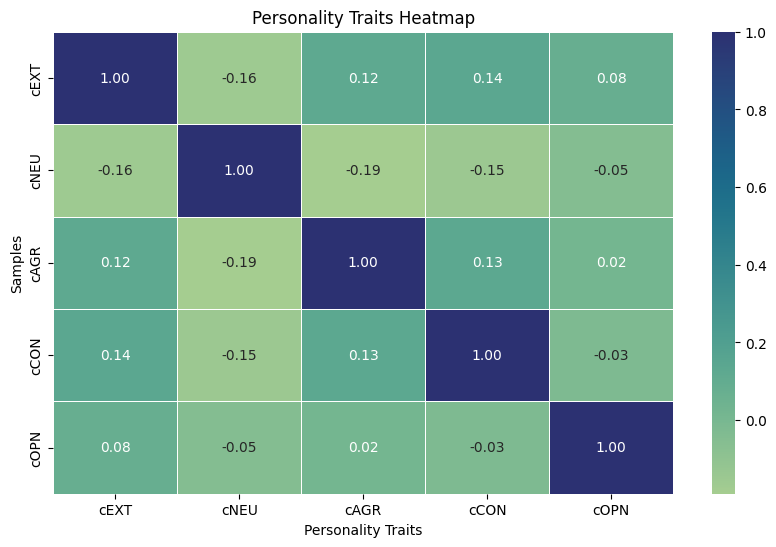

In [ ]:
#correlation between personality traits
#check to ensure traits correlate at similar rates to what is normal
heatmap_data = df.iloc[:, 2:7]
heatmap_data = heatmap_data.apply(pd.to_numeric)
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data.corr(), cmap = "crest", annot=True, fmt=".2f", linewidths=.5)
plt.xlabel('Personality Traits')
plt.ylabel('Samples')
plt.title("Personality Traits Heatmap")

plt.show()
#no highly significant correlation, which is to be expected.
#Correlation between neuroticism and all other personality traits are strongly negative in comparison to other traits
#to be expected, especially with extraversion and agreeableness


In [ ]:
#clean data
def cleanString(string):
    cleaned = re.sub(r'[^a-zA-Z\s]', '', string)
    cleaned = cleaned.lower()
    return cleaned

In [ ]:
#tokenize text (bag of words version)
def bow(string, bagOfWords):
  newString = cleanString(string)
  tokenized = newString.split(" ")
  for word in tokenized:
    if word in bagOfWords.keys():
      bagOfWords[word] += 1
    else:
      bagOfWords[word] = 1

  return bagOfWords

In [ ]:
#create bow for each category
personalities = {"cEXT": {},'cNEU': {}, 'cAGR': {}, 'cCON': {}, 'cOPN': {}}
for cat in personalities.keys():
  for essay in df.loc[df[cat] == 1]['TEXT']:
    personalities[cat] = bow(essay, personalities[cat])


#create bow for each categories negation
personalitiesNeg = {"cEXT": {},'cNEU': {}, 'cAGR': {}, 'cCON': {}, 'cOPN': {}}
for cat in personalitiesNeg.keys():
  for essay in df.loc[df[cat] == 0]['TEXT']:
    personalitiesNeg[cat] = bow(essay, personalitiesNeg[cat])



In [ ]:
words = {"cEXT": [],'cNEU': [], 'cAGR': [], 'cCON': [], 'cOPN': []}
for cat in personalities:
  for word in personalities[cat].keys():
      words[cat].append(word)


#what about frequencies of words at each length
lengthFreqs = {"cEXT": {},'cNEU': {}, 'cAGR': {}, 'cCON': {}, 'cOPN': {}}
for cat in words:
  for word in words[cat]:
    word = str(word)
    if len(word) > 20:
      continue
    if len(word) in lengthFreqs[cat].keys():
      lengthFreqs[cat][len(word)] += 1
    else:
      lengthFreqs[cat][len(word)] = 1


In [ ]:
# words in one category that arent in some other
important = {"cEXT": [],'cNEU': [], 'cAGR': [], 'cCON': [], 'cOPN': []}
for cat in personalities:
  for cat2 in personalities:
    for word in personalities[cat].keys():
      if word not in personalities[cat2].keys():
        important[cat].append(word)


In [ ]:
#different implementation: words in one category that arent in essays not labeled with that category
important = {"cEXT": [],'cNEU': [], 'cAGR': [], 'cCON': [], 'cOPN': []}
for cat in personalities:
  for word in personalities[cat].keys():
    if word not in personalitiesNeg[cat]:
      important[cat].append(word)

important["cCON"]

In [ ]:
# whats the average length of these important words?
# persons labeled open use the longest words on average
avgLengths = {"cEXT": 0,'cNEU': 0, 'cAGR': 0, 'cCON': 0, 'cOPN': 0}
for cat in important:
  total = 0
  for word in important[cat]:
    total += len(word)

  avgLengths[cat] = total/len(important[cat])



#what about frequencies of words at each length
lengthFreqs = {"cEXT": {},'cNEU': {}, 'cAGR': {}, 'cCON': {}, 'cOPN': {}}
for cat in important:
  for word in important[cat]:
    if len(word) > 20:
      continue
    if len(word) in lengthFreqs[cat].keys():
      lengthFreqs[cat][len(word)] += 1
    else:
      lengthFreqs[cat][len(word)] = 1


avgLengths

{'cEXT': 7.4599856542678555,
 'cNEU': 7.481161860660913,
 'cAGR': 7.502581044806938,
 'cCON': 7.607354420476137,
 'cOPN': 7.608899689935473}

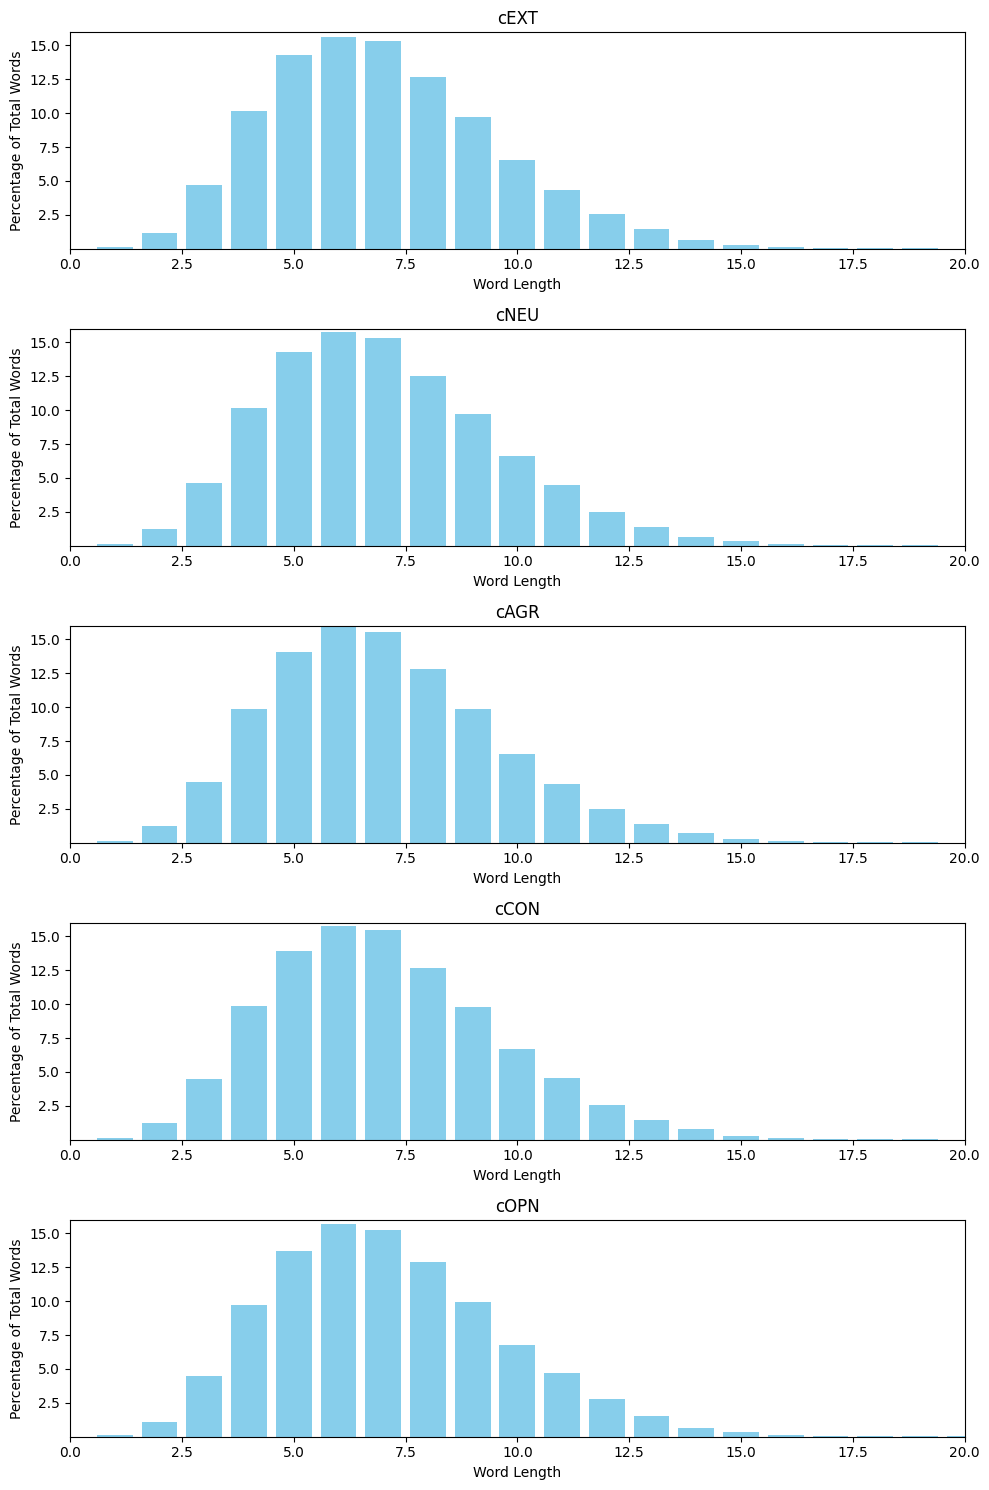

In [ ]:
#plot length percentages

# Calculate total word count for each personality trait
total_word_counts = {trait: sum(subdict.values()) for trait, subdict in lengthFreqs.items()}

# Calculate the percentage of each word length frequency relative to the total word count for each trait
percentage_freqs = {trait: {length: (count / total_word_counts[trait]) * 100 for length, count in subdict.items()} for trait, subdict in lengthFreqs.items()}

min_word_length = min(min(subdict.keys()) for subdict in lengthFreqs.values())
max_word_length = max(max(subdict.keys()) for subdict in lengthFreqs.values())

# min and max percentage frequencies across all traits
min_percentage = min(min(subdict.values()) for subdict in percentage_freqs.values())
max_percentage = max(max(subdict.values()) for subdict in percentage_freqs.values())

fig, axes = plt.subplots(5, 1, figsize=(10, 15))

for i, (personality_trait, subdict) in enumerate(percentage_freqs.items()):
    x = list(subdict.keys())
    y = list(subdict.values())

    axes[i].bar(x, y, color='skyblue')
    axes[i].set_title(personality_trait)
    axes[i].set_xlabel('Word Length')
    axes[i].set_ylabel('Percentage of Total Words')
    axes[i].set_xlim(min_word_length, max_word_length)
    axes[i].set_ylim(min_percentage, max_percentage)

plt.tight_layout()
plt.show()



In [ ]:
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Indexing word vectors.
Found 400000 word vectors.
